# Calculate and save driver beam parameters into a text file 
### Delete the v3_particles*.h5 files to save space
### IMPORTANT: 
The folders in the scan directory should be named like **density-5e14**

In [71]:
# Libraries
# #########
import os
import re
import sys
import h5py
import ast  # For safely evaluating string representations of lists
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.constants import c, pi, e, m_e, epsilon_0

# Below functions imported for density plots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator

# Directories' path
# #################
pyScripts_directory = '/home/novac/Desktop/my_projects/qv3d-automation/pyScripts'
synchrotron_dotpy = os.path.join(pyScripts_directory, 'synchrotron.py')
em_dotpy = os.path.join(pyScripts_directory, 'em.py')
plotDensities_dotpy = os.path.join(pyScripts_directory, 'plot_densities.py')
plotDensities_onlydriver_dotpy = os.path.join(pyScripts_directory, 'plot_densities_onlydriver.py')

sys.path.append(pyScripts_directory) # add the directory path into the memory where includes particles.py
from particles import getParameters, calculateParameters

# Constants
# #########
E0 = 0.5110e6  # [eV] electron rest energy

# Plot optoins
# ############
fontsize = 12
fontsize14 = 14
figsize = (7, 4)
best_density_range = [6e15, 3e16]
# Define colors for plotting (not used in this snippet, but could be useful if coloring points)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'navy']

# IMPORTANT - Set these parameters 
# ################################
only_driver = 1 # if witness included set this to 0
simulation_is_running = 0 # =1 if data still updating - it removes the last data that might be incopmplete

densityScan_dir = '/home/novac/Desktop/my_projects/qv3d-automation/data/onlyDriver' #'/home/novac/Desktop/my_projects/qv3d-automation/data/densScan-febe_acc'

# Save driver parameters then to delete the file
driver_processed_data_file   = '/home/novac/Desktop/my_projects/qv3d-automation/data/Do_Not_Delete/onlyDriver_MAIN_driverParameters.txt'
driver_processed_data_file_1 = '/home/novac/Desktop/my_projects/qv3d-automation/data/Do_Not_Delete/onlyDriver_part1_driverParameters.txt'
driver_processed_data_file_2 = '/home/novac/Desktop/my_projects/qv3d-automation/data/Do_Not_Delete/onlyDriver_part2_driverParameters.txt'

# Combine two parts
# #################
if os.path.exists(driver_processed_data_file_1) and os.path.exists(driver_processed_data_file_2):
    # Initialize an empty dictionary
    driver_dict1 = {}
    driver_dict2 = {}

    # Read the dictionary from the file 1
    with open(driver_processed_data_file_1, "r") as file:
        for line in file:
            # Split the line into key and value based on the colon
            key, value = line.strip().split(":", 1)
            
            # Convert the value (string representation of a list) back to a Python object using ast.literal_eval
            key = key.strip()  # Remove any extra spaces
            value = ast.literal_eval(value.strip())  # Safely evaluate the value as a Python object
            
            # Add the key-value pair to the dictionary
            driver_dict1[key] = value

    # Read the dictionary from the file 2
    with open(driver_processed_data_file_2, "r") as file:
        for line in file:
            # Split the line into key and value based on the colon
            key, value = line.strip().split(":", 1)
            
            # Convert the value (string representation of a list) back to a Python object using ast.literal_eval
            key = key.strip()  # Remove any extra spaces
            value = ast.literal_eval(value.strip())  # Safely evaluate the value as a Python object
            
            # Add the key-value pair to the dictionary
            driver_dict2[key] = value

    # add both dicts and write in one file
    combined_dict = {**driver_dict1, **driver_dict2}
    with open(driver_processed_data_file, "w") as file:
        for key, value in combined_dict.items():
            # Convert each numpy array in the list to a list
            if isinstance(value, list):  # If it's a list of arrays
                value = [v.tolist() if isinstance(v, np.ndarray) else v for v in value]
            
            # Write the key and value to the file
            file.write(f"{key}: {value}\n")


# Check if file exists
if os.path.exists(driver_processed_data_file):
    # Delete the file
    #os.remove(ML_data_file)
    driver_Datafile_is_available = 1
else:
    driver_Datafile_is_available = 0

In [72]:
def list_folders_in_dir(directory):
    """
    Lists and sorts all folders in a specified directory based on the numeric part 
    at the end of each folder's name.
    
    Parameters:
    - directory: Path to the directory containing folders to be listed and sorted.
    
    Returns:
    - A sorted list of folder names based on the numeric suffix in each name.
    
    Example:
    If the directory contains folders ['folder-10', 'folder-2', 'folder-30'], 
    list_folders_in_dir(directory) will return ['folder-2', 'folder-10', 'folder-30'].
    """
    # Check if the provided directory exists and is a directory
    if not os.path.isdir(directory):
        raise ValueError(f"The specified path '{directory}' is not a valid directory.")

    # List all items in the directory and filter to keep only folders
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

    # Sort the list of folders using the sort_by_last_numeric function
    sorted_folders = sorted(folders, key=lambda x: float(x.split('-')[-1])) 
    return sorted_folders

def get_mframeParameters(filepath):
    try:
        file=h5py.File(filepath,'r')
        #print("file = %s \n" % os.path.basename(filepath))
    except IOError:
        sys.stderr.write("File does not exist:\n  %s\n" % filepath)
        sys.exit(-1)
    
    phase = file['phase'][0]
    X = np.array(file.get('X'))
    Y = np.array(file.get('Y'))
    ex = np.array(file.get('ex'))
    n0 = np.array(file.get('n0'))
    n1 = np.array(file.get('n1'))
    n2 = np.array(file.get('n2'))
    ydim = Y.shape
    onaxisY2 = int(ydim[0]/2)
    ex_onaxis = ex[onaxisY2,:]
    distance = phase/kp     # [m]
    #print(lamdap, phase)
    return n0, n1, n2, ex, ex_onaxis, X, Y, distance



In [73]:
# Select folders h5files path
# ###########################
density_folders = list_folders_in_dir(densityScan_dir)

# remove last array as it might be ioncomplete
if simulation_is_running == 1:
    del density_folders[-1]

list_of_h5files_paths = []
for folder in density_folders:
    path = os.path.join(densityScan_dir, folder, 'h5files')
    list_of_h5files_paths.append(path)
    
# Generate density scan array based on the data folders
# #####################################################
# Regular expression to extract the numeric part after the last hyphen
pattern = re.compile(r'-([\d\.eE]+)$')

# Array to store numeric values in scientific notation
density_array = []

for folder in density_folders:
    match = pattern.search(folder)
    if match:
        # Convert the extracted part to float
        num = float(match.group(1))
        convert2_scientific_notation = f"{num:.2e}"

        # Append to the list
        density_array.append(convert2_scientific_notation)

# Convert to a NumPy array
density_array = np.array(density_array)

# Convert to float array
density_array = density_array.astype(float)
if not driver_Datafile_is_available:
    print(density_array)

In [74]:
if driver_Datafile_is_available:
    # Read the dictionary from the file
    keys = []
    with open(driver_processed_data_file, "r") as file:
        for line in file:
            # Split the line into key and value based on the colon
            key, value = line.strip().split(":", 1)
            
            # Convert the value (string representation of a list) back to a Python object using ast.literal_eval
            key = key.strip()  # Remove any extra spaces
            keys.append(key)

    # Extract numerical part using regex and convert to float
    float_values = [float(re.search(r"[\d.]+e[\d]+", item).group()) for item in keys]
    
    # Convert to a NumPy array (optional, depending on what you need)
    density_array = np.array(float_values)   
print(density_array)

[5.0e+14 5.1e+14 5.2e+14 5.3e+14 5.4e+14 5.5e+14 5.6e+14 5.7e+14 5.8e+14
 5.9e+14 6.0e+14 6.1e+14 6.2e+14 6.3e+14 6.4e+14 6.5e+14 6.6e+14 6.7e+14
 6.8e+14 6.9e+14 7.0e+14 7.1e+14 7.2e+14 7.3e+14 7.4e+14 7.5e+14 7.6e+14
 7.7e+14 7.8e+14 7.9e+14 8.0e+14 8.1e+14 8.2e+14 8.3e+14 8.4e+14 8.5e+14
 8.6e+14 8.7e+14 8.8e+14 8.9e+14 9.0e+14 9.1e+14 9.2e+14 9.3e+14 9.4e+14
 9.5e+14 9.6e+14 9.7e+14 9.8e+14 9.9e+14 1.0e+15 1.1e+15 1.2e+15 1.3e+15
 1.4e+15 1.5e+15 1.6e+15 1.7e+15 1.8e+15 1.9e+15 2.0e+15 2.1e+15 2.2e+15
 2.3e+15 2.4e+15 2.5e+15 2.6e+15 2.7e+15 2.8e+15 2.9e+15 3.0e+15 3.1e+15
 3.2e+15 3.3e+15 3.4e+15 3.5e+15 3.6e+15 3.7e+15 3.8e+15 3.9e+15 4.0e+15
 4.1e+15 4.2e+15 4.3e+15 4.4e+15 4.5e+15 4.6e+15 4.7e+15 4.8e+15 4.9e+15
 5.0e+15 5.1e+15 5.2e+15 5.3e+15 5.4e+15 5.5e+15 5.6e+15 5.7e+15 5.8e+15
 5.9e+15 6.0e+15 6.1e+15 6.2e+15 6.3e+15 6.4e+15 6.5e+15 6.6e+15 6.7e+15
 6.8e+15 6.9e+15 7.0e+15 7.1e+15 7.2e+15 7.3e+15 7.4e+15 7.5e+15 7.6e+15
 7.7e+15 7.8e+15 7.9e+15 8.0e+15 8.1e+15 8.2e+15 8.

# Plot wavebreaking field

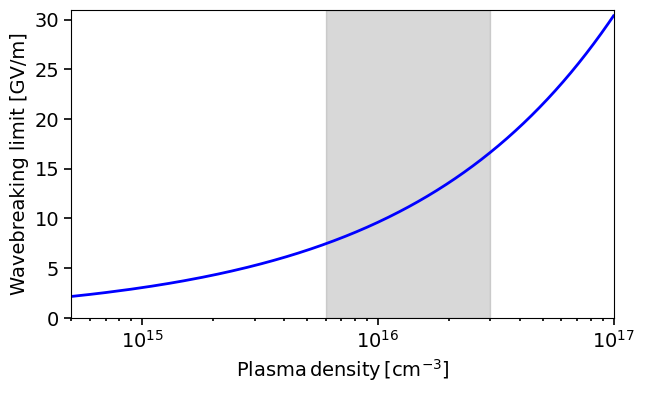

In [75]:
# Calculate Wavebreaking field
# ############################
#density = np.arange(density_array[0], density_array[-1], 1e14)
density = np.arange(1e14, 1e17, 1e14)
Ewb_array = np.zeros(len(density))

for i in range( len(density) ):
    n0 = density[i] * 1e6 # density in /m3

    wp = np.sqrt(n0*e**2/epsilon_0/m_e)
    kp=wp/c
    lamdap = 2*pi/kp
    Ewb = m_e*wp*c/e # wavebreaking field
    Ewb/=1e9 # in GV/m
    Ewb_array[i] = Ewb
    
# Plot wavebreaking 
# #################
fig, ax = plt.subplots(figsize=figsize)

# Customize tick parameters
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=2)


plt.plot(density, Ewb_array, color='b', linestyle='-', linewidth=2)

ax.set_xlim(5e14, 1e17)
ax.set_ylim(0, 31)
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size

# Add a shaded grey region between x1 and x2
ax.axvspan(best_density_range[0], best_density_range[1], color='grey', alpha=0.3, label='Shaded Region')

ax.set_xlabel(r'$\mathrm{Plasma \, density} \, [\mathrm{cm}^{-3}]$', fontsize=fontsize14)
ax.set_ylabel('Wavebreaking limit [GV/m]', fontsize=fontsize14)
plt.xscale('log')
#ax.grid(True, which="both", axis='y')

# Save the plot as both PDF and PNG
plt.savefig('Wavebreaking_density' + '.pdf', dpi=100, bbox_inches='tight')
plt.savefig('Wavebreaking_density' + '.png', dpi=100, bbox_inches='tight')

# Show the plot (optional, depending on the environment)
plt.show()
   

# Plot densities and the wakefield

In [76]:
def find_second_max(arr):
    # Step 1: Find the maximum value
    max_val = max(arr)
    
    # Step 2: Filter out all occurrences of the maximum
    filtered_arr = [x for x in arr if x != max_val]
    
    # Step 3: Find the maximum of the filtered list (second maximum)
    second_max = max(filtered_arr) if filtered_arr else None
    
    return second_max

# Example usage:
arr = [3, 1, 4, 4, 5, 5, 2]
second_maximum = find_second_max(arr)
print("The second maximum is:", second_maximum)


The second maximum is: 4


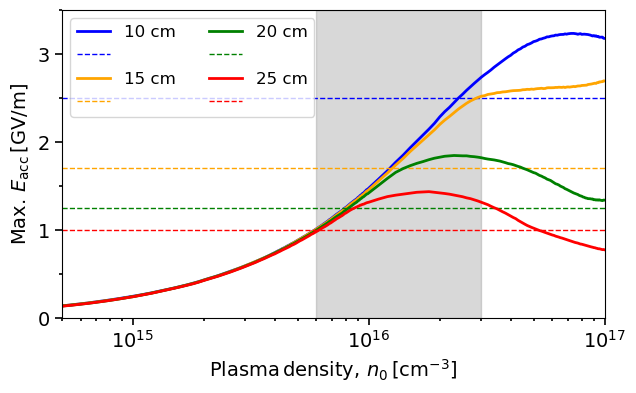

In [82]:
from pathlib import Path

acc_Wakefield_scan_0cm = []
acc_Wakefield_scan_5cm = []
acc_Wakefield_scan_10cm = []
acc_Wakefield_scan_15cm = []
acc_Wakefield_scan_20cm = []
acc_Wakefield_scan_25cm = []

dec_Wakefield_scan_0cm = []
dec_Wakefield_scan_5cm = []
dec_Wakefield_scan_10cm = []
dec_Wakefield_scan_15cm = []
dec_Wakefield_scan_20cm = []
dec_Wakefield_scan_25cm = []

#minWakefield_scan_30cm = []

for h5files_dir in list_of_h5files_paths:
    
    # Determine the density
    # #####################
    density_str = h5files_dir.split('density-')[1].split('/')[0]
    density = float(density_str)

    print('density = ', "{:.2e}".format(density), end="\r")  

    density*=1e6 #/m3
    wp = np.sqrt(density*e**2/epsilon_0/m_e)
    kp=wp/c
    lamdap = 2*pi/kp
    E_WB = c*m_e*wp/e # wavebreaking field
    E_WB/=1e9 #GeV
    
    # Select files to analyse
    # #######################    
    h5files_dir = Path(h5files_dir) # Specify the folder path

    # Use Path.glob() to list files matching the pattern
    v2d_mframe_files = list(h5files_dir.glob('v2d_mframe_*.h5'))

    # Sort the filenames based on the numeric part extracted from each filename
    sorted_v2d_mframe_files = sorted(v2d_mframe_files)
    number_of_output_spots = len(sorted_v2d_mframe_files)


    # Iterate over sorted_v2d_mframe_file
    for i, mframe_file in enumerate(sorted_v2d_mframe_files):
        n0, n1, n2, ex, ex_onaxis, X, Y, distance = get_mframeParameters(mframe_file)

        abs_acc_wakefield = abs( min(ex_onaxis) ) * E_WB # in GV/m as E_WB is in GV/m
        dec_wakefield = max(ex_onaxis) * E_WB # in GV/m as E_WB is in GV/m
        if i == 0:
            acc_Wakefield_scan_0cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_0cm.append(dec_wakefield)
        elif i == 1:
            acc_Wakefield_scan_5cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_5cm.append(dec_wakefield)
        elif i == 2:
            acc_Wakefield_scan_10cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_10cm.append(dec_wakefield)
        elif i == 3:
            acc_Wakefield_scan_15cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_15cm.append(dec_wakefield)
        elif i == 4:
            acc_Wakefield_scan_20cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_20cm.append(dec_wakefield)
        elif i == 5:
            acc_Wakefield_scan_25cm.append(abs_acc_wakefield)
            dec_Wakefield_scan_25cm.append(dec_wakefield)
#        elif i == 6:
#            minWakefield_scan_30cm.append(abs_min_wakefield)
            
# Plot maximum wakefield
# ######################
fig, ax = plt.subplots(figsize=figsize)
#fig, axs = plt.subplots(2, 1, figsize=(6, 8))

###################################
#ax = axs[0]
# Customize tick parameters
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=2)

# Scatter plot with colors and sizes
#ax.scatter(density_array, minWakefield_scan_0cm, c='k', s=14, alpha=1, marker='x', label = '0 cm')
#plt.plot(density_array, minWakefield_scan_0cm, color='orange', linestyle='-', linewidth=2)

#ax.scatter(density_array, minWakefield_scan_5cm, c='r', s=14, alpha=1, marker='s', label = '5 cm')
#plt.plot(density_array, minWakefield_scan_5cm, color='orange', linestyle='-', linewidth=2)

#ax.scatter(density_array, minWakefield_scan_10cm, c='b', s=14, alpha=1, marker='^')
ax.plot(density_array, acc_Wakefield_scan_10cm, color=colors[0], linestyle='-', linewidth=2, label = '10 cm')
ax.axhline(y=2.5, color=colors[0], linewidth=1, ls='--', label = ' ')  # Add a horizontal line at y=0

#ax.scatter(density_array, minWakefield_scan_15cm, c='g', s=14, alpha=1, marker='o')
ax.plot(density_array, acc_Wakefield_scan_15cm, color=colors[1], linestyle='-', linewidth=2, label = '15 cm')
ax.axhline(y=1.7, color=colors[1], linewidth=1, ls='--', label = ' ')  # Add a horizontal line at y=0

#ax.scatter(density_array, minWakefield_scan_20cm, c='c', s=14, alpha=1, marker='^'
ax.plot(density_array, acc_Wakefield_scan_20cm, color=colors[2], linestyle='-', linewidth=2, label = '20 cm')
ax.axhline(y=1.25, color=colors[2], linewidth=1, ls='--', label = ' ')  # Add a horizontal line at y=0

#ax.scatter(density_array, minWakefield_scan_25cm, c='k', s=14, alpha=1, marker='d')
ax.plot(density_array, acc_Wakefield_scan_25cm, color=colors[3], linestyle='-', linewidth=2, label = '25 cm')
ax.axhline(y=1, color=colors[3], linewidth=1, ls='--', label = ' ')  # Add a horizontal line at y=0

#ax.scatter(density_array, minWakefield_scan_20cm, c='c', s=14, alpha=1, marker='^'
#plt.plot(density_array, minWakefield_scan_30cm, color=colors[4], linestyle='-', linewidth=2, label = '30 cm')
#plt.axhline(y=1.25, color=colors[4], linewidth=1, ls='--', label = ' ')  # Add a horizontal line at y=0

ax.set_ylim(0, 3.5)
ax.set_xlim(5e14, 1e17)
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size

#ax.set_xlim(density_array[0], density_array[-1])
#ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Change 14 to your desired font size

ax.minorticks_on()
ax.tick_params(axis='both', which='major')#, length=7, width=1.5)
ax.tick_params(axis='both', which='minor')#, length=4, width=1, color='gray')
ax.yaxis.set_major_locator(MultipleLocator(1))  # Minor ticks every 5 units
ax.yaxis.set_minor_locator(MultipleLocator(.5))  # Minor ticks every 5 units


ax.legend(ncol=2, loc='upper left', fontsize=fontsize)

ax.set_xlabel(r'$\mathrm{Plasma \, density,} \, n_0 \, [\mathrm{cm}^{-3}]$', fontsize=fontsize14)
ax.set_ylabel(r'$\mathrm{Max.} \, E_\mathrm{acc} \, \mathrm{[GV/m]}$', fontsize=fontsize14)
ax.set_xscale('log')
#plt.yscale('log')
#ax.grid(True, which="both", axis='x')

# Add a shaded grey region between x1 and x2
ax.axvspan(best_density_range[0], best_density_range[1], color='grey', alpha=0.3, label='Shaded Region')

# Save the plot as both PDF and PNG
plt.savefig('maxWakefield' + '.pdf', dpi=100, bbox_inches='tight')
plt.savefig('maxWakefield' + '.png', dpi=100, bbox_inches='tight')

# Show the plot (optional, depending on the environment)
plt.show()
   

# Save data into text file


In [63]:
#list_of_h5files_paths = list_of_h5files_paths[:5]
#density_array = density_array[:5]
#driver_densities = driver_densities[:5]

driver_dict = {}
driver_parameters_for_allSimulation = []
witness_parameters_for_allSimulation = []
#list_of_h5files_paths = list_of_h5files_paths[:5]

if not driver_Datafile_is_available:
    for path_h5files in list_of_h5files_paths:
    
        #################################################
        # Split by '-' and take the last part of 'density-7e14'
        density_str = path_h5files.split('density-')[1].split('/')[0]
        density = float(density_str)

        print("{:.2e}".format(density), end="\r")  # Output: 7e14
    
        density*=1e6 #/m3
        wp = np.sqrt(density*e**2/epsilon_0/m_e)
        kp=wp/c
        lamdap = 2*pi/kp
        E_WB = c*m_e*wp/e # wavebreaking field
        E_WB/=1e9 #GeV
        ####################################################
    
        # #########################
        # Analyze driver parameters
        # #########################
        
        #driver_parameters_for_1simulation = []
        energys_driver = []
        energySpreads_driver = []
        dists_driver = []
        charges_driver = []
        emittances_driver = []
    
        energys_witness = []
        energySpreads_witness = []
        dists_witness = []
        charges_witness = []
        emittances_witness = []
        for i in range(1,number_of_output_spots+1): # this is the range of number of files
            # Get the particles data
            simulation_directory = os.path.dirname(path_h5files)
            new_path_h5files = os.path.dirname(path_h5files)
    
            # driver
            # ######
            driver_values = !python {em_dotpy} -ol {new_path_h5files} {i} 1
            phase, wmg, stdev_g, W, lamdap, emittance, lamdap=getParameters(driver_values[0])
            energy, energySpread, dist, charge = calculateParameters(phase,wmg,stdev_g,W,lamdap)
        
            energys_driver  = np.append(energys_driver, energy)
            energySpreads_driver = np.append(energySpreads_driver, energySpread)
            dists_driver = np.append(dists_driver, dist)
            charges_driver = np.append(charges_driver, charge)
            emittances_driver = np.append(emittances_driver, emittance)
    
        # parameters at differnet locations
        driver_parameters_for_1simulation = [energys_driver, energySpreads_driver, dists_driver, charges_driver, emittances_driver]
        
        driver_dict['Driver@PlasmaDensityOf '+density_str] = driver_parameters_for_1simulation
         
    with open(driver_processed_data_file, "w") as file:
        for key, value in driver_dict.items():
            # Convert each numpy array in the list to a list
            if isinstance(value, list):  # If it's a list of arrays
                value = [v.tolist() if isinstance(v, np.ndarray) else v for v in value]
            
            # Write the key and value to the file
            file.write(f"{key}: {value}\n")

else:
    print('The file arelady exists!')


The file arelady exists!


In [64]:
import ast  # For safely evaluating string representations of lists

driver_parameters_for_allSimulation = []
# Initialize an empty dictionary
driver_dict = {}

# Read the dictionary from the file
with open(driver_processed_data_file, "r") as file:
    for line in file:
        # Split the line into key and value based on the colon
        key, value = line.strip().split(":", 1)
        
        # Convert the value (string representation of a list) back to a Python object using ast.literal_eval
        key = key.strip()  # Remove any extra spaces
        value = ast.literal_eval(value.strip())  # Safely evaluate the value as a Python object
        
        # Add the key-value pair to the dictionary
        driver_dict[key] = value
        driver_parameters_for_allSimulation.append(value)

# Print the resulting dictionary
#print(driver_dict)


In [65]:
energy_scan_0cm = []
energy_scan_5cm = []
energy_scan_10cm = []
energy_scan_15cm = []
energy_scan_20cm = []
energy_scan_25cm = []
#energy_scan_30cm = []

charge_scan_0cm = []
charge_scan_5cm = []
charge_scan_10cm = []
charge_scan_15cm = []
charge_scan_20cm = []
charge_scan_25cm = []
#charge_scan_30cm = []

chargeLoss_scan_0cm = []
chargeLoss_scan_5cm = []
chargeLoss_scan_10cm = []
chargeLoss_scan_15cm = []
chargeLoss_scan_20cm = []
chargeLoss_scan_25cm = []
#charge_scan_30cm = []

for i in range(len(driver_parameters_for_allSimulation)):
    driver_parameters = driver_parameters_for_allSimulation[i]
    energys  = driver_parameters[0]
    energySpreads = driver_parameters[1]
    dists = driver_parameters[2]
    charges = driver_parameters[3]
    emittances = driver_parameters[4]

    energy_scan_0cm.append(energys[0]/1e6)
    energy_scan_5cm.append(energys[1]/1e6)
    energy_scan_10cm.append(energys[2]/1e6)
    energy_scan_15cm.append(energys[3]/1e6)
    energy_scan_20cm.append(energys[4]/1e6)
    energy_scan_25cm.append(energys[5]/1e6)
#    energy_scan_30cm.append(energys[6]/1e6)

    charge_scan_0cm.append(charges[0]/1e-12)
    charge_scan_5cm.append(charges[1]/1e-12)
    charge_scan_10cm.append(charges[2]/1e-12)
    charge_scan_15cm.append(charges[3]/1e-12)
    charge_scan_20cm.append(charges[4]/1e-12)
    charge_scan_25cm.append(charges[5]/1e-12)
#    charge_scan_30cm.append(charges[6]/1e-12)

    q0 = 200 #pC
    chargeloss = abs(charges[0]/1e-12 -q0)/q0*100
    chargeLoss_scan_0cm.append(chargeloss)

    chargeloss = abs(charges[1]/1e-12 -q0)/q0*100
    chargeLoss_scan_5cm.append(chargeloss)

    chargeloss = abs(charges[2]/1e-12 -q0)/q0*100
    chargeLoss_scan_10cm.append(chargeloss)

    chargeloss = abs(charges[3]/1e-12 -q0)/q0*100
    chargeLoss_scan_15cm.append(chargeloss)

    chargeloss = abs(charges[4]/1e-12 -q0)/q0*100
    chargeLoss_scan_20cm.append(chargeloss)

    chargeloss = abs(charges[5]/1e-12 -q0)/q0*100
    chargeLoss_scan_25cm.append(chargeloss)
#    charge_scan_30cm.append(charges[6]/1e-12)


# Calculate Driver beam density

In [66]:
list_of_vini_paths = []
for folder in density_folders:
    path = os.path.join(densityScan_dir, folder, 'v.ini')
    list_of_vini_paths.append(path)

driver_densities = []

for vini_path in list_of_vini_paths:
    #print(vini_path)
    
    # Initialize variables to track when &Specie1 is encountered and to store the density value
    density_after_specie2 = None
    found_specie2 = False
    
    # Open and read the file line by line
    with open(vini_path, "r") as file:
        for line in file:
            # Check if &Specie2 is in the line to start searching for Density after it
            if "&Specie1" in line:
                found_specie2 = True
        
            # Once &Specie2 has been found, look for the first Density value after it
            elif found_specie2 and "Density" in line:
                # Extract the numeric part after the "=" sign and strip any whitespace
                density_str = line.split('=')[1].strip().split()[0]
                # Convert the extracted value to float
                density_after_specie2 = float(density_str)
                break  # Stop searching after finding the first Density value after &Specie2

    # Print or use the density value
    if density_after_specie2 is not None:
        driver_densities.append(density_after_specie2)
    else:
        print("Density value after &Specie1 not found in file.")


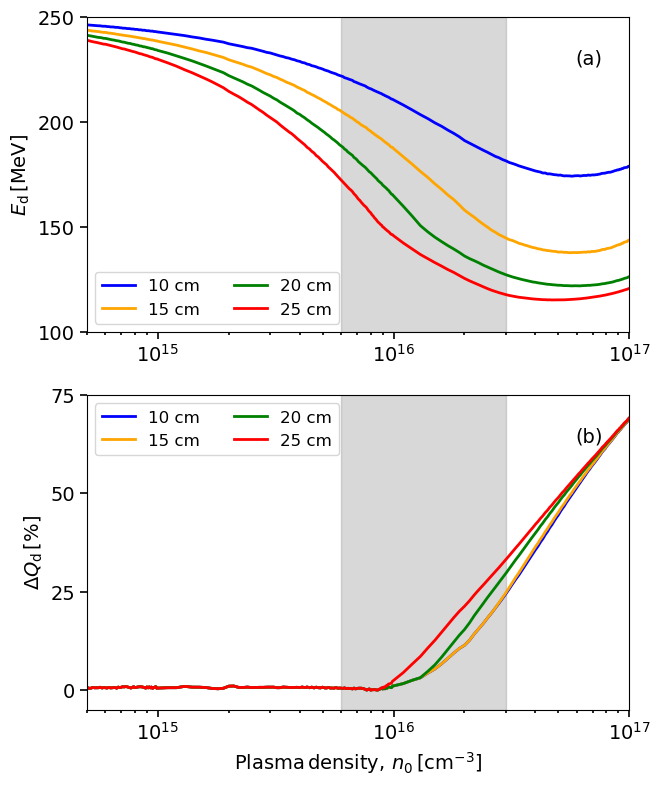

In [88]:
#driver_densities = driver_densities[:5]
# Assuming 'driver_parameters_for_allSimulation' and 'energys' are defined elsewhere
# Create an array based on the length of 'driver_parameters_for_allSimulation'
#arr = np.arange(1, len(driver_parameters_for_allSimulation) + 1)

# Set font size and create a figure with specified size
figsize = (7, 9)  # Taller height for a 3-row vertical layout
fig, axes = plt.subplots(2, 1, figsize=figsize)  # 3 rows, 1 column

# Driver energy
# #############
ax = axes[0]

# Customize tick parameters
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=2)

# Set y-axis label (Uncomment if needed)
# ax.set_ylabel(r'$k_\mathrm{p}y$', fontsize=fontsize)

# Scatter plot with colors and sizes
#ax.scatter(density_array, energy_scan_0cm, c=colors[0], s=14, alpha=1, marker='x', label = '0 cm')
#plt.plot(density_array, energy_scan_0cm, color=colors[0], linestyle='-', linewidth=2, label = '0 cm')

#ax.scatter(density_array, energy_scan_5cm, c=colors[1], s=14, alpha=1, marker='s', label = '5 cm')
#plt.plot(density_array, energy_scan_5cm, color=colors[1], linestyle='-', linewidth=2, label = '5 cm')

#ax.scatter(density_array, energy_scan_10cm, c=colors[2], s=14, alpha=1, marker='^', label = '10 cm')
ax.plot(density_array, energy_scan_10cm, color=colors[0], linestyle='-', linewidth=2, label = '10 cm')

#ax.scatter(density_array, energy_scan_15cm, c=colors[3], s=14, alpha=1, marker='o', label = '15 cm')
ax.plot(density_array, energy_scan_15cm, color=colors[1], linestyle='-', linewidth=2, label = '15 cm')

#ax.scatter(density_array, energy_scan_20cm, c=colors[4], s=14, alpha=1, marker='^', label = '20 cm')
ax.plot(density_array, energy_scan_20cm, color=colors[2], linestyle='-', linewidth=2, label = '20 cm')

#ax.scatter(density_array, energy_scan_25cm, c=colors[5], s=14, alpha=1, marker='d', label = '25 cm')
ax.plot(density_array, energy_scan_25cm, color=colors[3], linestyle='-', linewidth=2, label = '25 cm')

#ax.scatter(density_array, energy_scan_30cm, c=colors[5], s=14, alpha=1, marker='d', label = '30 cm')
#plt.plot(density_array, energy_scan_30cm, color=colors[6], linestyle='-', linewidth=2, label = '30 cm')

# Add a color bar to visualize the color mapping (optional)
#plt.colorbar(label='Color intensity')

ax.set_ylim(100, 250)
ax.set_xlim(5e14, 1e17)
ax.yaxis.set_major_locator(MultipleLocator(50))  # Minor ticks every 5 units

ax.legend(ncol=2, loc='lower left', fontsize=fontsize)

#ax.set_xlabel(r'$\mathrm{Plasma \, density} \, [\mathrm{cm}^{-3}]$', fontsize=12)
ax.set_ylabel(r'$E_\mathrm{d} \, [\mathrm{MeV}]$', fontsize=fontsize14)
ax.set_xscale('log')
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')

# Add a shaded grey region between x1 and x2
ax.axvspan(best_density_range[0], best_density_range[1], color='grey', alpha=0.3, label='Shaded Region')
   
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size

# Driver charge
# #############
ax = axes[1]
# Customize tick parameters
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=2)

# Set y-axis label (Uncomment if needed)
# ax.set_ylabel(r'$k_\mathrm{p}y$', fontsize=fontsize)

# Define colors for plotting (not used in this snippet, but could be useful if coloring points)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'navy']



# Scatter plot with colors and sizes
#ax.scatter(density_array, charge_scan_5cm, c=colors[0], s=14, alpha=1, marker='s', label = '0 cm')
#plt.plot(density_array, charge_scan_0cm, color=colors[0], linestyle='-', linewidth=2, label = '0 cm')

#ax.scatter(density_array, charge_scan_5cm, c=colors[1], s=14, alpha=1, marker='s', label = '5 cm')
#plt.plot(density_array, charge_scan_5cm, color=colors[1], linestyle='-', linewidth=2, label = '5 cm')

#ax.scatter(density_array, charge_scan_10cm, c=colors[2], s=14, alpha=1, marker='^', label = '10 cm')
ax.plot(density_array, chargeLoss_scan_10cm, color=colors[0], linestyle='-', linewidth=2, label = '10 cm')

#ax.scatter(density_array, charge_scan_15cm, c=colors[3], s=14, alpha=1, marker='o', label = '15 cm')
ax.plot(density_array, chargeLoss_scan_15cm, color=colors[1], linestyle='-', linewidth=2, label = '15 cm')

#ax.scatter(density_array, charge_scan_20cm, c=colors[4], s=14, alpha=1, marker='^', label = '20 cm')
ax.plot(density_array, chargeLoss_scan_20cm, color=colors[2], linestyle='-', linewidth=2, label = '20 cm')

#ax.scatter(density_array, charge_scan_25cm, c=colors[5], s=14, alpha=1, marker='d', label = '25 cm')
ax.plot(density_array, chargeLoss_scan_25cm, color=colors[3], linestyle='-', linewidth=2, label = '25 cm')

#ax.scatter(density_array, charge_scan_25cm, c=colors[6], s=14, alpha=1, marker='d', label = '25 cm')
#plt.plot(density_array, charge_scan_30cm, color=colors[6], linestyle='-', linewidth=2, label = '30 cm')

# Add a color bar to visualize the color mapping (optional)
#plt.colorbar(label='Color intensity')

ax.set_xlabel(r'$\mathrm{Plasma \, density,} \, n_0 \, [\mathrm{cm}^{-3}]$', fontsize=fontsize14)
ax.set_ylabel('Driver energy [MeV]', fontsize=fontsize14)
ax.set_xscale('log')
ax.legend(ncol=2, loc='upper left', fontsize=fontsize)

# Add a shaded grey region between x1 and x2
ax.axvspan(best_density_range[0], best_density_range[1], color='grey', alpha=0.3, label='Shaded Region')

ax.set_ylabel(r'$\Delta Q_\mathrm{d} \, [\%]$', fontsize=fontsize14)
ax.set_ylim(-5, 75)
ax.set_xlim(5e14, 1e17)
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')

# Apply the intervals
#ax.xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size



# Save the plot as both PDF and PNG
plt.savefig('driver' + '.pdf', dpi=100, bbox_inches='tight')
plt.savefig('driver' + '.png', dpi=100, bbox_inches='tight')

# Show the plot (optional, depending on the environment)
plt.show()


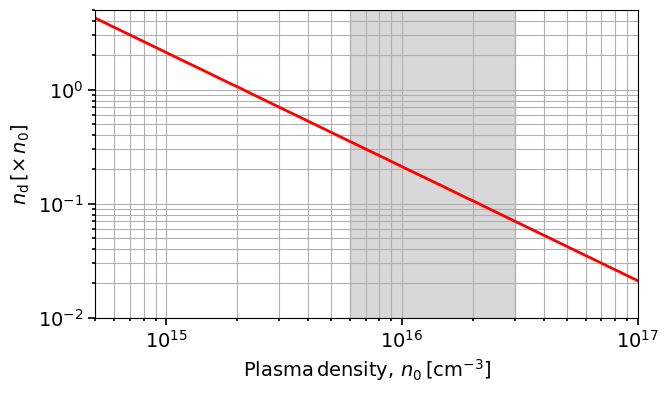

In [86]:
# Plot maximum wakefield
# ######################
figsize = (7, 4)
fig, ax = plt.subplots(figsize=figsize)
#fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Driver density
# ##############
#ax = axes[2]

# Customize tick parameters
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=2)

# Set y-axis label (Uncomment if needed)
# ax.set_ylabel(r'$k_\mathrm{p}y$', fontsize=fontsize)

# Define colors for plotting (not used in this snippet, but could be useful if coloring points)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'navy']



#ax.scatter(density_array, charge_scan_25cm, c=colors[5], s=14, alpha=1, marker='d', label = '25 cm')
ax.plot(density_array, driver_densities, color=colors[3], linestyle='-', linewidth=2, label = '25 cm')

# Add a color bar to visualize the color mapping (optional)
#plt.colorbar(label='Color intensity')

ax.set_xlabel(r'$\mathrm{Plasma \, density,} \, n_0 \, [\mathrm{cm}^{-3}]$', fontsize=fontsize14)
ax.set_ylabel(r'$n_\mathrm{d} \, [\times \, n_0]$', fontsize=fontsize14)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.legend(ncol=2, loc='lower left', fontsize=10)

# Add a shaded grey region between x1 and x2
ax.axvspan(best_density_range[0], best_density_range[1], color='grey', alpha=0.3, label='Shaded Region')

#ax.set_ylabel('Driver charge [pC]', fontsize=fontsize14)
ax.set_ylim(0.01, 5)
ax.set_xlim(5e14, 1e17)

# Apply the intervals
#ax.xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
#ax.yaxis.set_major_locator(MultipleLocator(50))
ax.grid(True, which="both", axis='y')
ax.grid(True, which="both", axis='x')

#ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size

# Save the plot as both PDF and PNG
plt.savefig('driverDensity' + '.pdf', dpi=100, bbox_inches='tight')
plt.savefig('driverDensity' + '.png', dpi=100, bbox_inches='tight')

# Show the plot (optional, depending on the environment)
plt.show()